In [141]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [142]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1.

In [144]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [145]:
X, y = make_moons(n_samples=1000, random_state=42)
X[:5], y[:5]

(array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        [ 0.46587532, -0.34540571],
        [-0.85041204,  0.52611726]]),
 array([1, 1, 1, 1, 0], dtype=int64))

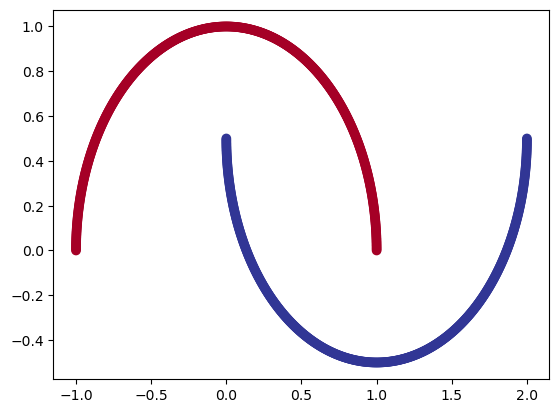

In [146]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [147]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

# 2.

In [151]:
from torch import nn

In [152]:
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features=1, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_0 = MoonModel(input_features=2).to(device)
model_0

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

# 3.

In [154]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# 4.

In [156]:
from helper_functions import accuracy_fn

In [171]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    ### Training
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
        

    

Epoch: 0 | Loss: 0.71196, Accuracy: 50.00% | Test Loss: 0.70563, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.36001, Accuracy: 84.50% | Test Loss: 0.37441, Test Accuracy: 83.00%
Epoch: 200 | Loss: 0.23690, Accuracy: 88.88% | Test Loss: 0.24050, Test Accuracy: 89.50%
Epoch: 300 | Loss: 0.21527, Accuracy: 89.88% | Test Loss: 0.21518, Test Accuracy: 91.50%
Epoch: 400 | Loss: 0.19347, Accuracy: 91.12% | Test Loss: 0.19230, Test Accuracy: 92.00%
Epoch: 500 | Loss: 0.15933, Accuracy: 93.12% | Test Loss: 0.15809, Test Accuracy: 93.00%
Epoch: 600 | Loss: 0.11417, Accuracy: 95.38% | Test Loss: 0.11280, Test Accuracy: 96.50%
Epoch: 700 | Loss: 0.07176, Accuracy: 98.50% | Test Loss: 0.06996, Test Accuracy: 98.00%
Epoch: 800 | Loss: 0.04407, Accuracy: 100.00% | Test Loss: 0.04219, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.02877, Accuracy: 100.00% | Test Loss: 0.02706, Test Accuracy: 100.00%


# 5.

In [184]:
from helper_functions import plot_decision_boundary

In [182]:
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test).squeeze()))
y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

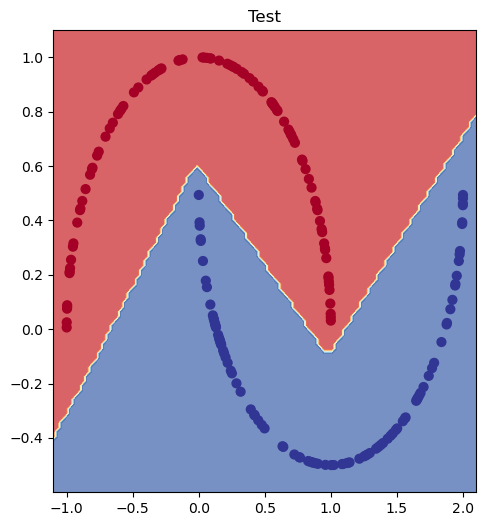

In [186]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 6.

In [ ]:
def tanh(z):
    return ((torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z)))

# 7.

In [258]:
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

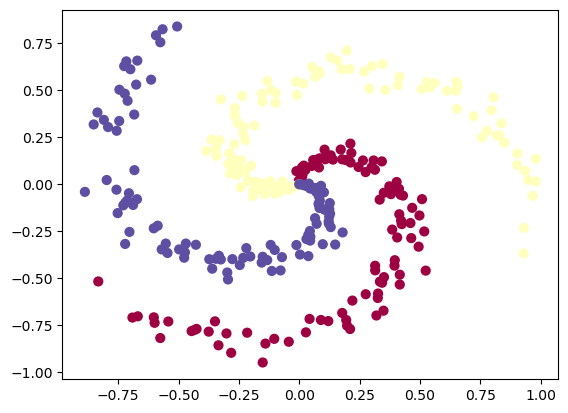

In [260]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [262]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [266]:
X_train.shape, y_train.shape

(torch.Size([240, 2]), torch.Size([240]))

In [268]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=3),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [270]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.5)
accuracy = MulticlassAccuracy(num_classes=3).to(device)

In [284]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 3000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

        loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.23449, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 100 | Loss: 0.23372, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 200 | Loss: 0.23294, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 300 | Loss: 0.23217, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 400 | Loss: 0.23141, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 500 | Loss: 0.23065, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 600 | Loss: 0.22989, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 700 | Loss: 0.22914, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 800 | Loss: 0.22840, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 900 | Loss: 0.22767, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 1000 | Loss: 0.22695, Accuracy: 0.96% | Test Loss: 0.01878, Test Accuracy: 0.93%
Epoch: 1100 | Loss: 0.22627, Accuracy: 0.96%

In [290]:
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:5], y_test[:5]

(tensor([2, 2, 1, 0, 2], device='cuda:0'),
 tensor([2, 2, 1, 0, 2], device='cuda:0'))

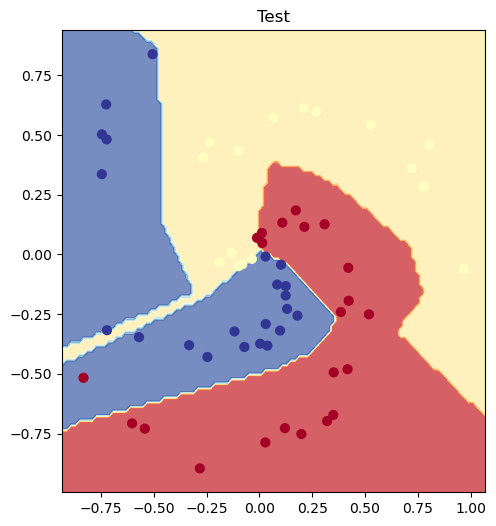

In [294]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)